In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import cv2
import os
from tqdm import tqdm
from PIL import Image
import torchvision.models as models

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
!wget https://www.dropbox.com/s/pxcz2wdz04zxocq/CamVid.zip?dl=1 -O CamVid.zip
!unzip -qq CamVid.zip

--2019-02-20 15:28:34--  https://www.dropbox.com/s/pxcz2wdz04zxocq/CamVid.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/pxcz2wdz04zxocq/CamVid.zip [following]
--2019-02-20 15:28:40--  https://www.dropbox.com/s/dl/pxcz2wdz04zxocq/CamVid.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc08eb028c0ab1d9407508574f65.dl.dropboxusercontent.com/cd/0/get/Abs-Ss8cJhazm4bdxaP2-36A0ZRtdE05xBg0pyQyRdu3_JDfg7uKHePrsnCmRbBTQ2Q2BZcRgIaKaNQRflDTxY_2z3ZuBdxErr2PxlMYeMSE4A/file?dl=1# [following]
--2019-02-20 15:28:40--  https://uc08eb028c0ab1d9407508574f65.dl.dropboxusercontent.com/cd/0/get/Abs-Ss8cJhazm4bdxaP2-36A0ZRtdE05xBg0pyQyRdu3_JDfg7uKHePrsnCmRbBTQ2Q2BZcRgIaKaNQRflDTxY_2z3ZuBdxErr2PxlMYeMSE4A/file?dl=1
Resolving uc08e

In [0]:
class ASSP(nn.Module):
  def __init__(self,in_channels,out_channels = 256):
    super(ASSP,self).__init__()
    
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    
    self.conv1 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 1,
                          padding = 0,
                          dilation=1)
    
    self.conv2 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 3,
                          padding = 6,
                          dilation = 6)
    
    self.conv3 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 3,
                          padding = 12,
                          dilation = 12)
    
    self.conv4 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 3,
                          padding = 18,
                          dilation = 18)
    
    self.conv5 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 1,
                          padding = 0,
                          dilation=1)
    
    self.convf = nn.Conv2d(in_channels = out_channels * 5, 
                          out_channels = out_channels,
                          kernel_size = 1,
                          padding = 0,
                          dilation=1)
    
    self.adapool = nn.AdaptiveAvgPool2d(1)
    
    
   
  
  def forward(self,x):
    
    x1 = self.conv1(x)
    x1 = self.bn(x1)
    x1 = self.relu(x1)
    
    x2 = self.conv2(x)
    x2 = self.bn(x2)
    x2 = self.relu(x2)
    
    x3 = self.conv3(x)
    x3 = self.bn(x3)
    x3 = self.relu(x3)
    
    x4 = self.conv4(x)
    x4 = self.bn(x4)
    x4 = self.relu(x4)
    
    x5 = self.adapool(x)
    x5 = self.conv5(x5)
    x5 = self.bn(x5)
    x5 = F.interpolate(self.relu(x5), size = tuple(x4.shape[-2:]), mode='bilinear')
    
    #print (x1.shape, x2.shape, x3.shape, x4.shape, x5.shape)
    x = torch.cat((x1,x2,x3,x4,x5), dim = 1) #channels first
    x = self.convf(x)
    x = self.bn(x)
    x = self.relu(x)
    
    return x

In [0]:
class ResNet_50 (nn.Module):
  def __init__(self, in_channels = 3, conv1_out = 64):
    super(ResNet_50,self).__init__()
    
    self.in_channels = in_channels
    
    self.conv1_out = conv1_out
    
    self.resnet_50 = models.resnet50(pretrained = True)
    
    self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = conv1_out, 
                           kernel_size=(7,7), stride = 2)
    
    self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2)
  
  def forward(self,x):
    x = self.conv1(x)
    x = self.maxpool(x)
    x = self.resnet_50.layer1(x)
    x = self.resnet_50.layer2(x)
    x = self.resnet_50.layer3(x)
    
    
    return x

In [0]:
class DeepLabv3(nn.Module):
  def __init__(self,nc = 12):
    super(DeepLabv3, self).__init__()
    
    self.nc = nc
    
    self.resnet = ResNet_50()
    
    self.assp = ASSP(in_channels = 1024)
    
    self.conv = nn.Conv2d(in_channels = 256, out_channels = self.nc,
                          kernel_size = 1)
    
  def forward(self,x):
    
    x = self.resnet(x)
    x = self.assp(x)
    x = F.interpolate(self.conv(x), scale_factor = 16)
    return x

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
a = torch.rand(2, 3, 512, 512).float()
a = a.to(device)
model = DeepLabv3(12)
model.to(device)
with torch.no_grad():
  out = model(a)
  
out.shape

torch.Size([2, 256, 32, 32]) torch.Size([2, 256, 32, 32]) torch.Size([2, 256, 32, 32]) torch.Size([2, 256, 32, 32]) torch.Size([2, 256, 32, 32])


torch.Size([2, 12, 512, 512])

In [0]:
def loader(training_path, segmented_path, batch_size, h=320, w=1000):
    filenames_t = os.listdir(training_path)
    total_files_t = len(filenames_t)
    
    filenames_s = os.listdir(segmented_path)
    total_files_s = len(filenames_s)
    
    assert(total_files_t == total_files_s)
    
    if str(batch_size).lower() == 'all':
        batch_size = total_files_s
    
    idx = 0
    while(1):
      # Choosing random indexes of images and labels
        batch_idxs = np.random.randint(0, total_files_s, batch_size)
                    
        inputs = []
        labels = []
        
        for jj in batch_idxs:
          # Reading normalized photo
            img = plt.imread(training_path + filenames_t[jj])
          # Resizing using nearest neighbor method
            img = cv2.resize(img, (h, w), cv2.INTER_NEAREST)
            inputs.append(img)
          
          # Reading semantic image
            img = Image.open(segmented_path + filenames_s[jj])
            img = np.array(img)
          # Resizing using nearest neighbor method
            img = cv2.resize(img, (h, w), cv2.INTER_NEAREST)
            labels.append(img)
         
        inputs = np.stack(inputs, axis=2)
      # Changing image format to C x H x W
        inputs = torch.tensor(inputs).transpose(0, 2).transpose(1, 3)
        
        labels = torch.tensor(labels)
        
        yield inputs, labels

In [0]:
def get_class_weights(loader, num_classes, c=1.02):
    '''
    This class return the class weights for each class
    
    Arguments:
    - loader : The generator object which return all the labels at one iteration
               Do Note: That this class expects all the labels to be returned in
               one iteration
    - num_classes : The number of classes
    Return:
    - class_weights : An array equal in length to the number of classes
                      containing the class weights for each class
    '''

    _, labels = next(loader)
    all_labels = labels.flatten()
    each_class = np.bincount(all_labels, minlength=num_classes)
    prospensity_score = each_class / len(all_labels)
    class_weights = 1 / (np.log(c + prospensity_score))
    return class_weights

In [0]:
###############################
# Global Variables Section
training_path = '/content/train/'
segmented_path = '/content/trainannot/'
eval_path = '/content/test/'
segmented_eval_path = '/content/testannot/'
nc = 12
H = 512
W = 512
batch_size = 8
lr = 0.007
epochs = 50
train_samples = len(os.listdir(training_path))
eval_samples = len(os.listdir(eval_path))
save_every = 1
print_every = 1
eval_every = 1

In [0]:
###############################

model = DeepLabv3()
model = model.to(device)

In [0]:
###############################
# Create here two loaders

pipe = loader(training_path, segmented_path, batch_size, h = H, w = W)
eval_pipe = loader(eval_path, segmented_eval_path, batch_size, h = H, w = W)

In [0]:
###############################

class_weights = get_class_weights(pipe, nc)
criterion = nn.CrossEntropyLoss(weight = torch.FloatTensor(class_weights).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)

In [25]:
train_losses = []
eval_losses = []

bc_train = train_samples // batch_size
bc_eval = eval_samples // batch_size

for e in range(1, epochs+1):

    train_loss = 0
    print ('-'*15,'Epoch %d' % e, '-'*15)

    model.train()

    for _ in tqdm(range(bc_train)):
        X_batch, mask_batch = next(pipe)

        X_batch, mask_batch = X_batch.to(device), mask_batch.to(device)

        optimizer.zero_grad()

        out = model(X_batch.float())

        loss = criterion(out, mask_batch.long())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    print ()
    train_losses.append(train_loss)

    if (e+1) % print_every == 0:
        print ('Epoch {}/{}...'.format(e, epochs),
                'Loss {:6f}'.format(train_loss))

    if e % eval_every == 0:
        with torch.no_grad():
            model.eval()

            eval_loss = 0

            for _ in tqdm(range(bc_eval)):
                inputs, labels = next(eval_pipe)

                inputs, labels = inputs.to(device), labels.to(device)
                out = model(inputs)

                loss = criterion(out, labels.long())

                eval_loss += loss.item()

            print ()
            print ('Loss {:6f}'.format(eval_loss))

            eval_losses.append(eval_loss)

    if e % save_every == 0:
        checkpoint = {
            'epochs' : e,
            'state_dict' : model.state_dict()
        }
        torch.save(checkpoint, './ckpt-enet-{}-{}.pth'.format(e, train_loss))
        print ('Model saved!')


  0%|          | 0/45 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))

100%|██████████| 45/45 [03:54<00:00,  5.32s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 1/50... Loss 73.105967



100%|██████████| 29/29 [01:31<00:00,  3.07s/it]



Loss 58.360845



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 2 ---------------



100%|██████████| 45/45 [03:51<00:00,  5.24s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 2/50... Loss 60.912962



100%|██████████| 29/29 [01:30<00:00,  3.06s/it]



Loss 46.135388



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 3 ---------------



100%|██████████| 45/45 [03:49<00:00,  5.23s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 3/50... Loss 56.169190



100%|██████████| 29/29 [01:30<00:00,  3.06s/it]



Loss 48.374265



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 4 ---------------



100%|██████████| 45/45 [03:45<00:00,  5.04s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 4/50... Loss 54.564267



100%|██████████| 29/29 [01:30<00:00,  3.07s/it]



Loss 50.060102



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 5 ---------------



100%|██████████| 45/45 [03:45<00:00,  5.17s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 5/50... Loss 52.417226



100%|██████████| 29/29 [01:30<00:00,  3.02s/it]



Loss 44.856050



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 6 ---------------



100%|██████████| 45/45 [02:02<00:00,  2.73s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 6/50... Loss 49.564319



100%|██████████| 29/29 [00:57<00:00,  1.97s/it]



Loss 52.903069



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 7 ---------------



100%|██████████| 45/45 [02:02<00:00,  2.71s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 7/50... Loss 50.609842



100%|██████████| 29/29 [00:56<00:00,  1.97s/it]




Loss 53.439085
Model saved!
--------------- Epoch 8 ---------------


100%|██████████| 45/45 [02:01<00:00,  2.71s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 8/50... Loss 47.051829



100%|██████████| 29/29 [00:56<00:00,  1.95s/it]

  0%|          | 0/45 [00:00<?, ?it/s]


Loss 46.081270
Model saved!
--------------- Epoch 9 ---------------



100%|██████████| 45/45 [02:01<00:00,  2.70s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 9/50... Loss 46.029075



100%|██████████| 29/29 [00:57<00:00,  1.97s/it]



Loss 53.763412



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 10 ---------------



100%|██████████| 45/45 [02:01<00:00,  2.70s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 10/50... Loss 45.667533



100%|██████████| 29/29 [00:56<00:00,  1.96s/it]

  0%|          | 0/45 [00:00<?, ?it/s]


Loss 45.235948
Model saved!
--------------- Epoch 11 ---------------



100%|██████████| 45/45 [02:01<00:00,  2.70s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 11/50... Loss 44.722308



100%|██████████| 29/29 [00:57<00:00,  1.96s/it]




Loss 52.288299
Model saved!
--------------- Epoch 12 ---------------


100%|██████████| 45/45 [02:01<00:00,  2.70s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 12/50... Loss 44.312615



100%|██████████| 29/29 [00:56<00:00,  1.96s/it]




Loss 46.018584
Model saved!
--------------- Epoch 13 ---------------


100%|██████████| 45/45 [02:01<00:00,  2.69s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 13/50... Loss 39.910315



100%|██████████| 29/29 [00:56<00:00,  1.96s/it]



Loss 57.959085



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 14 ---------------



100%|██████████| 45/45 [02:01<00:00,  2.68s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 14/50... Loss 40.123239



100%|██████████| 29/29 [00:57<00:00,  1.95s/it]



Loss 51.655916



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 15 ---------------



100%|██████████| 45/45 [02:01<00:00,  2.69s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 15/50... Loss 39.733137



100%|██████████| 29/29 [00:56<00:00,  1.97s/it]



Loss 47.542291



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 16 ---------------



100%|██████████| 45/45 [02:00<00:00,  2.69s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 16/50... Loss 39.207625



100%|██████████| 29/29 [00:56<00:00,  1.96s/it]



Loss 46.154867



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 17 ---------------



100%|██████████| 45/45 [02:00<00:00,  2.68s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 17/50... Loss 38.821390



100%|██████████| 29/29 [00:56<00:00,  1.95s/it]



Loss 56.103354



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 18 ---------------



100%|██████████| 45/45 [02:00<00:00,  2.68s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 18/50... Loss 37.572620



100%|██████████| 29/29 [00:56<00:00,  1.95s/it]



Loss 48.974147



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 19 ---------------



100%|██████████| 45/45 [02:00<00:00,  2.68s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 19/50... Loss 36.987628



100%|██████████| 29/29 [00:56<00:00,  1.95s/it]



Loss 55.496422



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 20 ---------------



100%|██████████| 45/45 [02:00<00:00,  2.68s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 20/50... Loss 38.403592



100%|██████████| 29/29 [00:56<00:00,  1.96s/it]



Loss 45.418198



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 21 ---------------



100%|██████████| 45/45 [02:00<00:00,  2.68s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 21/50... Loss 35.726706



100%|██████████| 29/29 [00:56<00:00,  1.96s/it]



Loss 40.387905



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 22 ---------------



100%|██████████| 45/45 [02:00<00:00,  2.67s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 22/50... Loss 37.032186



100%|██████████| 29/29 [00:56<00:00,  1.95s/it]



Loss 55.569869



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 23 ---------------



100%|██████████| 45/45 [02:00<00:00,  2.68s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 23/50... Loss 35.826362



100%|██████████| 29/29 [00:56<00:00,  1.96s/it]



Loss 47.988963



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 24 ---------------



100%|██████████| 45/45 [02:00<00:00,  2.68s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 24/50... Loss 36.053931



100%|██████████| 29/29 [00:56<00:00,  1.97s/it]



Loss 53.256766



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 25 ---------------



100%|██████████| 45/45 [02:00<00:00,  2.68s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 25/50... Loss 36.362850



100%|██████████| 29/29 [00:56<00:00,  1.95s/it]



Loss 49.832469



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 26 ---------------



100%|██████████| 45/45 [02:00<00:00,  2.67s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 26/50... Loss 35.454484



100%|██████████| 29/29 [00:56<00:00,  1.95s/it]



Loss 45.913625



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 27 ---------------



100%|██████████| 45/45 [02:00<00:00,  2.66s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 27/50... Loss 34.654313



100%|██████████| 29/29 [00:56<00:00,  1.94s/it]



Loss 52.807970



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 28 ---------------



100%|██████████| 45/45 [01:59<00:00,  2.67s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 28/50... Loss 33.933671



100%|██████████| 29/29 [00:56<00:00,  1.97s/it]



Loss 59.606181



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 29 ---------------



100%|██████████| 45/45 [01:59<00:00,  2.66s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 29/50... Loss 34.443044



100%|██████████| 29/29 [00:56<00:00,  1.95s/it]



Loss 58.761774



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 30 ---------------



100%|██████████| 45/45 [02:00<00:00,  2.67s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 30/50... Loss 34.923430



100%|██████████| 29/29 [00:56<00:00,  1.95s/it]



Loss 59.129780



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 31 ---------------



100%|██████████| 45/45 [02:00<00:00,  2.67s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 31/50... Loss 34.716263



100%|██████████| 29/29 [00:56<00:00,  1.95s/it]



Loss 61.701871



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 32 ---------------



100%|██████████| 45/45 [02:00<00:00,  2.66s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 32/50... Loss 32.905184



100%|██████████| 29/29 [00:56<00:00,  1.95s/it]



Loss 52.097448



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 33 ---------------



100%|██████████| 45/45 [01:59<00:00,  2.66s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 33/50... Loss 33.897568



100%|██████████| 29/29 [00:56<00:00,  1.95s/it]



Loss 43.682895



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 34 ---------------



100%|██████████| 45/45 [01:59<00:00,  2.67s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 34/50... Loss 34.192105



100%|██████████| 29/29 [00:56<00:00,  1.94s/it]



Loss 50.928427



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 35 ---------------



100%|██████████| 45/45 [01:59<00:00,  2.67s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 35/50... Loss 33.792845



100%|██████████| 29/29 [00:56<00:00,  1.95s/it]



Loss 102.645502



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 36 ---------------



100%|██████████| 45/45 [01:59<00:00,  2.66s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 36/50... Loss 32.592160



100%|██████████| 29/29 [00:56<00:00,  1.96s/it]



Loss 61.212758



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 37 ---------------



100%|██████████| 45/45 [01:58<00:00,  2.64s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 37/50... Loss 32.461818



100%|██████████| 29/29 [00:55<00:00,  1.92s/it]



Loss 47.474593



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 38 ---------------



100%|██████████| 45/45 [01:58<00:00,  2.63s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 38/50... Loss 32.244313



100%|██████████| 29/29 [00:55<00:00,  1.93s/it]



Loss 47.233468



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 39 ---------------



100%|██████████| 45/45 [01:58<00:00,  2.63s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 39/50... Loss 32.141763



100%|██████████| 29/29 [00:55<00:00,  1.92s/it]



Loss 42.573287



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 40 ---------------



100%|██████████| 45/45 [01:59<00:00,  2.65s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 40/50... Loss 31.552557



100%|██████████| 29/29 [00:56<00:00,  1.93s/it]



Loss 49.758412



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 41 ---------------



100%|██████████| 45/45 [01:58<00:00,  2.63s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 41/50... Loss 31.089481



100%|██████████| 29/29 [00:55<00:00,  1.92s/it]



Loss 43.601088



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 42 ---------------



100%|██████████| 45/45 [01:58<00:00,  2.63s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 42/50... Loss 31.333915



100%|██████████| 29/29 [00:55<00:00,  1.91s/it]



Loss 64.954030



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 43 ---------------



100%|██████████| 45/45 [01:58<00:00,  2.62s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 43/50... Loss 31.922272



100%|██████████| 29/29 [00:55<00:00,  1.92s/it]



Loss 47.918521



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 44 ---------------



100%|██████████| 45/45 [01:58<00:00,  2.63s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 44/50... Loss 30.972585



100%|██████████| 29/29 [00:55<00:00,  1.92s/it]



Loss 89.639476



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 45 ---------------



100%|██████████| 45/45 [01:58<00:00,  2.63s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 45/50... Loss 31.733583



100%|██████████| 29/29 [00:55<00:00,  1.92s/it]



Loss 47.012056



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 46 ---------------



100%|██████████| 45/45 [01:58<00:00,  2.63s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 46/50... Loss 31.823291



100%|██████████| 29/29 [00:55<00:00,  1.91s/it]



Loss 55.913675



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 47 ---------------



100%|██████████| 45/45 [01:58<00:00,  2.62s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 47/50... Loss 30.823813



100%|██████████| 29/29 [00:55<00:00,  1.91s/it]



Loss 56.145859



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 48 ---------------



100%|██████████| 45/45 [01:57<00:00,  2.62s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 48/50... Loss 31.995852



100%|██████████| 29/29 [00:55<00:00,  1.91s/it]



Loss 57.800978



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 49 ---------------



100%|██████████| 45/45 [01:58<00:00,  2.63s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 49/50... Loss 31.081248



100%|██████████| 29/29 [00:55<00:00,  1.93s/it]



Loss 61.677624



  0%|          | 0/45 [00:00<?, ?it/s]

Model saved!
--------------- Epoch 50 ---------------



100%|██████████| 45/45 [01:58<00:00,  2.65s/it]

  0%|          | 0/29 [00:00<?, ?it/s]


Epoch 50/50... Loss 31.256611



100%|██████████| 29/29 [00:55<00:00,  1.91s/it]



Loss 56.968056
Model saved!


In [26]:
fname = '0001TP_010140.png'
tmg_ = plt.imread('/content/test/' + fname)
tmg_ = cv2.resize(tmg_, (512, 512), cv2.INTER_NEAREST)
tmg = torch.tensor(tmg_).unsqueeze(0).float()
tmg = tmg.transpose(2, 3).transpose(1, 2).to(device)

model.to(device)
with torch.no_grad():
    out1 = model(tmg.float()).squeeze(0)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:
smg_ = Image.open('/content/testannot/' + fname)
smg_ = cv2.resize(np.array(smg_), (512, 512), cv2.INTER_NEAREST)

In [0]:
out2 = out1.cpu().detach().numpy()

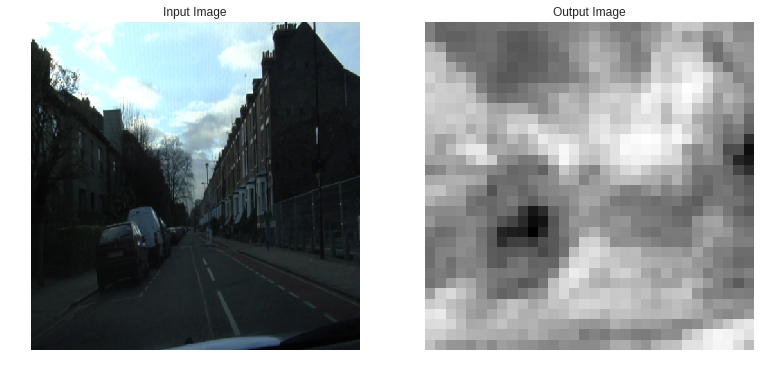

In [29]:
mno = 8 # Should be between 0 - n-1 | where n is the number of classes

figure = plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.axis('off')
plt.imshow(tmg_)
plt.subplot(1, 3, 2)
plt.title('Output Image')
plt.axis('off')
plt.imshow(out2[mno, :, :])
plt.show()

In [0]:
b_ = out1.data.max(0)[1].cpu().numpy()

In [0]:
def decode_segmap(image):
    Sky = [128, 128, 128]
    Building = [128, 0, 0]
    Pole = [192, 192, 128]
    Road_marking = [255, 69, 0]
    Road = [128, 64, 128]
    Pavement = [60, 40, 222]
    Tree = [128, 128, 0]
    SignSymbol = [192, 128, 128]
    Fence = [64, 64, 128]
    Car = [64, 0, 128]
    Pedestrian = [64, 64, 0]
    Bicyclist = [0, 128, 192]

    label_colours = np.array([Sky, Building, Pole, Road_marking, Road, 
                              Pavement, Tree, SignSymbol, Fence, Car, 
                              Pedestrian, Bicyclist]).astype(np.uint8)
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, 12):
        r[image == l] = label_colours[l, 0]
        g[image == l] = label_colours[l, 1]
        b[image == l] = label_colours[l, 2]

    rgb = np.zeros((image.shape[0], image.shape[1], 3)).astype(np.uint8)
    rgb[:, :, 0] = b
    rgb[:, :, 1] = g
    rgb[:, :, 2] = r
    return rgb

In [0]:
true_seg = decode_segmap(smg_)
pred_seg = decode_segmap(b_)

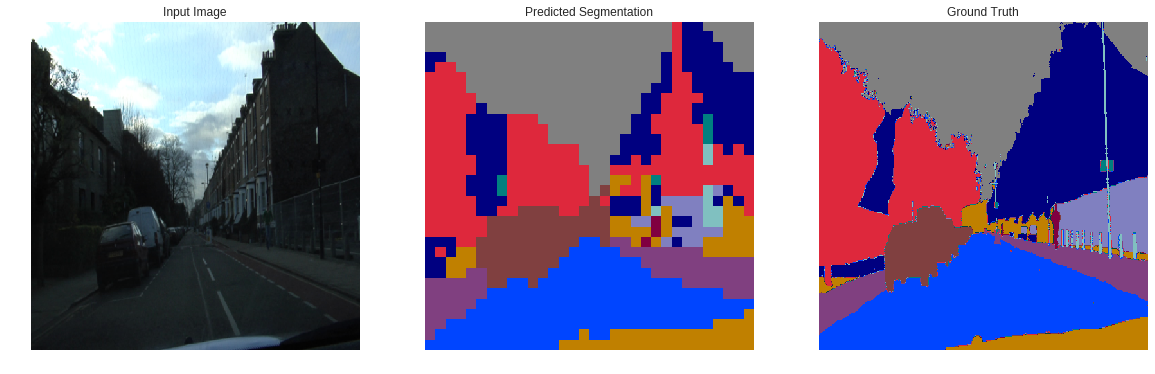

In [36]:
figure = plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.axis('off')
plt.imshow(tmg_)
plt.subplot(1, 3, 2)
plt.title('Predicted Segmentation')
plt.axis('off')
plt.imshow(pred_seg)
plt.subplot(1, 3, 3)
plt.title('Ground Truth')
plt.axis('off')
plt.imshow(true_seg)
plt.show()

In [0]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class ConvBlock(nn.Module):
  def __init__(self,in_channels,out_channels,side_branch = True):
    super(ConvBlock,self).__init__()
    
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.side_branch = side_branch
    
    self.relu = nn.ReLU()
    
    self.sep_conv1 = SeparableConv2d(in_channels = self.in_channels,
                          out_channels = self.out_channels,
                          kernel_size = 3,
                          padding = 1)
    self.sep_conv2 = SeparableConv2d(in_channels = self.out_channels,
                          out_channels = self.out_channels,
                          kernel_size = 3,
                          padding = 1)
    self.sep_conv3 = SeparableConv2d(in_channels = self.in_channels,
                          out_channels = self.out_channels,
                          kernel_size = 3,
                          padding = 1,
                          stride = 2)
    self.conv4 = nn.Conv2d(in_channels = self.in_channels,
                          out_channels = self.out_channels,
                          kernel_size = 1,
                          padding = 1,
                          stride = 2)
    self.batchnorm = nn.BatchNorm2d()
      
        
  def forward(self,x):
    main = self.sep_conv1(x)    
    main = self.batchnorm(main)
    main = self.relu(main)
    main = self.sep_conv2(x)    
    main = self.batchnorm(main)
    main = self.relu(main)
    main = self.sep_conv3(x)    
    main = self.batchnorm(main)
    main = self.relu(main)
    
    if side_branch:
      side = F.relu(self.conv4(x))
      
    try:
      return side + main
    
    except:
      return x + main